#Generating QPSI Timeseries figures#

###Loading rpy2 for running R within a python environment###

In [2]:
#This loads the rpy2 package that allows R to operate within a python environment
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


##Creating Z-score heatmaps for Poplar and Sorghum##
- We will use the Zscore_from_GO_term_list() function within the BioinformaticLibrary.py file in order to extract all of the genes associated with selected GO terms.
- This function requires 1) A file with a list of GO terms of interest, 2) A normalized count file where replicate treatments have already been averaged, and 3) GO annotation table that lists the genes associated with each GO term. 
- This function will average expression within each GO term and output a csv file with Zscores generated by row.
- Since Zscore values are relative to the samples being compared, Zscore values will change as you subset samples from the full sample comparison.
- In order to make things easier, you can subset the full set of samples sequentially as many as 2 times. 
- For example, we may be interested in generating a heatmap of root samples only vs leaf samples only.
- Or, as in this case, we want to look at every TissueXTreatment comparison separately we can subset samples by leaf and root and then by the metal treatments (i.e., FeEx, FeLim, etc.)
- Subsetting is optional and can not be used entirely
###Make sure the BioinformaticsLibrary.py file is in your current working directory###

In [1]:
#Import the library containing the functions we will be using
#Make sure this file is in your current directory
import BioinformaticsLibrary as BL #This can be found in the Python Scripts directory. Make sure the BioinformaticsLibrary.py script is in your working directory

In [3]:
#Generate Poplar Zscore .csv files that will be used as input for ComplexHeatmap in R
BL.Zscore_from_GO_term_list(GO_term_file='Poplar_ion_clp_cellwall_GO_extracted_genes_L2FCtmmSplit.xlsx', 
                            count_file='Ptr_average_TMM.csv',
                            GO_annotation_file='Ptr_GO_annotation.tsv',
                            output_name='Poplar',
                            subset_list_1=['Leaf', 'Root'],
                            subset_list_2=['FeEx', 'FeLim', 'ZnEx', 'ZnLim'])

In [4]:
#Generate Sorghum Zscore .csv files that will be used as input for ComplexHeatmap in R
BL.Zscore_from_GO_term_list(GO_term_file='Sorghum_ion_clp_cellwall_GO_extracted_genes_L2FCtmmSplit.xlsx', 
                            count_file='Sbi_average_TMM.csv',
                            GO_annotation_file='Sbi_GO_annotation.tsv',
                            output_name='Sorghum',
                            subset_list_1=['Leaf', 'Root'], 
                            subset_list_2=['FeEx', 'FeLim', 'ZnEx', 'ZnLim'])

##Python Function Output##
- These functions will output a number of files according the the subset lists included
- For the purposes of this notebook we are only interested in the "Full_Sorghum.csv" file and the "Full_Poplar.csv" output files

##Using ComplexHeatmap in R to create Heatmaps##
###Creating heatmap for Sorghum###

In [10]:
%%R
#Make full Sorghum Zscore Heatmap
library(ComplexHeatmap)
library(dendextend)
library(circlize)
library(dplyr)
library(RColorBrewer)
library(tidyr)

mat1 <- read.csv('Full_Sorghum.csv', row=1)

metadata <- read.csv('All_metadata.csv')

#Change "TissueXTrtXTime" string with treatment column from your metadata file
#that corresponds the names on your data matrix file
#################################################################################
metadata <- metadata %>% distinct(TissueXTrtXTime, .keep_all = TRUE) #Change this
#mat %>% select(matches())

mat1<-na.omit(mat1)
mat2 <- mat1
#Comment out the line below if you are working with Gene expression data
#mat1 <- t(mat1) #comment out this line if working with gene expression data
for ( col in 1:ncol(mat2)){
  colnames(mat2)[col] <-  gsub("_", " ", colnames(mat2)[col])
}


mat1 <- data.matrix(mat1)
mat2 <- data.matrix(mat2)
column_tree = hclust(dist(t(mat1)))
column_order <- column_tree$labels

#Change "TissueXTrtXTime" to the column that corresponds to your count labels
#######################################################################################
meta2 <- arrange(metadata, factor(metadata$TissueXTrtXTime, levels=column_order)) #change this

####################################################################################
####################################################################################
#Create vectors for heatmap annotation, 1 vector per annotation
trt <- meta2$Treatment
tiss <- meta2$Tissue
time <- meta2$Time

#Change colors and categories based on the treatment (column)
ha <- HeatmapAnnotation(
  tissue = tiss,
  treatment = trt,
  timepoint = time,
  col=list(tissue=structure(names=c("Leaf","Root"), c("green","brown")),
           treatment=structure(names=c("FeEx","Control","FeLim", "ZnEx", "ZnLim"), c("red2","royalblue","limegreen", "gold", "purple")),
           timepoint=structure(names=c("0h","1h", "2d", "4d", "7d",
                                       "14d", "21d"), brewer.pal(7,"OrRd"))),
  border=TRUE,
  show_legend=c(TRUE,TRUE,TRUE),
  show_annotation_name=FALSE,
  annotation_legend_param = list(
    tissue= list(title="Tissue Type", title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16)),
    treatment= list(title="Metal Treatment", title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16)),
    timepoint= list(title="Time Point", title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16), at=c("0h","1h", "2d", "4d", "7d",
                    "14d", "21d")))
)

#Change row_km and column_km for the number of clusters you want to generate
ht_list <- Heatmap(mat2, column_title="Sorghum Enriched GO Term Expression", name = "Zscore", column_km=6, column_gap=unit(2, "mm"),
                   bottom_annotation=ha,
                   column_names_gp=gpar(fontsize=14),
                   row_names_gp=gpar(fontsize=14),
                   width=ncol(mat2)*unit(5,"mm"),
                   height=nrow(mat2)*unit(5, "mm"),
                   heatmap_legend_param=list(title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16)),
                   column_title_gp = gpar(fontsize = 30, fontface = "bold"))

##################################################################################

#Change filename
pdf("Sorghum_Full_Clusters_zscore.pdf",width=26,height=8) #Change this

draw(ht_list, annotation_legend_side = "left", heatmap_legend_side = "left",
     padding = unit(c(2, 5, 2, 20), "mm"))

dev.off()


############################################################################################

R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


R[write to console]: 
---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgal

png 
  2 


###Creating heatmap for Poplar###

In [11]:
%%R

#Make Poplar
mat1 <- read.csv('Full_Poplar.csv', row=1)

metadata <- read.csv('All_metadata.csv')

#Change "TissueXTrtXTime" string with treatment column from your metadata file
#that corresponds the names on your data matrix file
#################################################################################
metadata <- metadata %>% distinct(TissueXTrtXTime, .keep_all = TRUE) #Change this
#mat %>% select(matches())

mat1<-na.omit(mat1)
mat2 <- mat1
#Comment out the line below if you are working with Gene expression data
#mat1 <- t(mat1) #comment out this line if working with gene expression data
for ( col in 1:ncol(mat2)){
  colnames(mat2)[col] <-  gsub("_", " ", colnames(mat2)[col])
}


mat1 <- data.matrix(mat1)
mat2 <- data.matrix(mat2)
column_tree = hclust(dist(t(mat1)))
column_order <- column_tree$labels

#Change "TissueXTrtXTime" to the column that corresponds to your count labels
#######################################################################################
meta2 <- arrange(metadata, factor(metadata$TissueXTrtXTime, levels=column_order)) #change this

####################################################################################
####################################################################################
#Create vectors for heatmap annotation, 1 vector per annotation
trt <- meta2$Treatment
tiss <- meta2$Tissue
time <- meta2$Time

#Change colors and categories based on the treatment (column)
ha <- HeatmapAnnotation(
  tissue = tiss,
  treatment = trt,
  timepoint = time,
  col=list(tissue=structure(names=c("Leaf","Root"), c("green","brown")),
           treatment=structure(names=c("FeEx","Control","FeLim", "ZnEx", "ZnLim"), c("red2","royalblue","limegreen", "gold", "purple")),
           timepoint=structure(names=c("0h","1h", "2d", "4d", "7d",
                                       "14d", "21d"), brewer.pal(7,"OrRd"))),
  border=TRUE,
  show_legend=c(TRUE,TRUE,TRUE),
  show_annotation_name=FALSE,
  annotation_legend_param = list(
    tissue= list(title="Tissue Type", title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16)),
    treatment= list(title="Metal Treatment", title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16)),
    timepoint= list(title="Time Point", title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16), at=c("0h","1h", "2d", "4d", "7d",
                                                                                                                       "14d", "21d")))
)

#Change row_km and column_km for the number of clusters you want to generate
ht_list <- Heatmap(mat2, column_title="Poplar Enriched GO Term Expression", name = "Zscore", column_km=6, column_gap=unit(2, "mm"),
                   bottom_annotation=ha,
                   column_names_gp=gpar(fontsize=14),
                   row_names_gp=gpar(fontsize=14),
                   width=ncol(mat2)*unit(5,"mm"),
                   height=nrow(mat2)*unit(5, "mm"),
                   heatmap_legend_param=list(title_gp=gpar(fontsize=20, fontface="bold"), labels_gp=gpar(fontsize=16)),
                   column_title_gp = gpar(fontsize = 30, fontface = "bold"))

###################################################################################
##################################################################################

#Change filename
pdf("Poplar_Full_Clusters_zscore.pdf",width=26,height=12) #Change this

draw(ht_list, annotation_legend_side = "left", heatmap_legend_side = "left",
     padding = unit(c(2, 5, 2, 20), "mm"))

dev.off()


png 
  2 


##Creating GO enrichment dotplots##
- In this section we wil use another python function from the BioinformaticsLibrary.py file
- This function requires you to provide either 3 separate GO enrichment files or a compiled GO enrichment file. You do not have to perform enrichments on all 3 GO categories in order to run this function.
- Regardless of what you provide, this function will attempt to make BP, MF, and CC plots as well as a final compiled plot. 
- If you do not provide enrichments for 1 or more GO categories, those plots will simply be blank.
- There is an optional sort_list argument that allows you to dictate the order of GO terms on the Y-axis.
- We will use this sort_list argument to have the order of the enrichment dotplot Y-axis match the Y-axis from Z-score heatmap
###Enrichment dotplot for Sorghum###

not working


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\mclea\OneDrive\Brookhaven\AWS\Jupyter_Notebooks\QPSI\BioinformaticsLibrary.py:462: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(ax, yticklabels=sort_list)


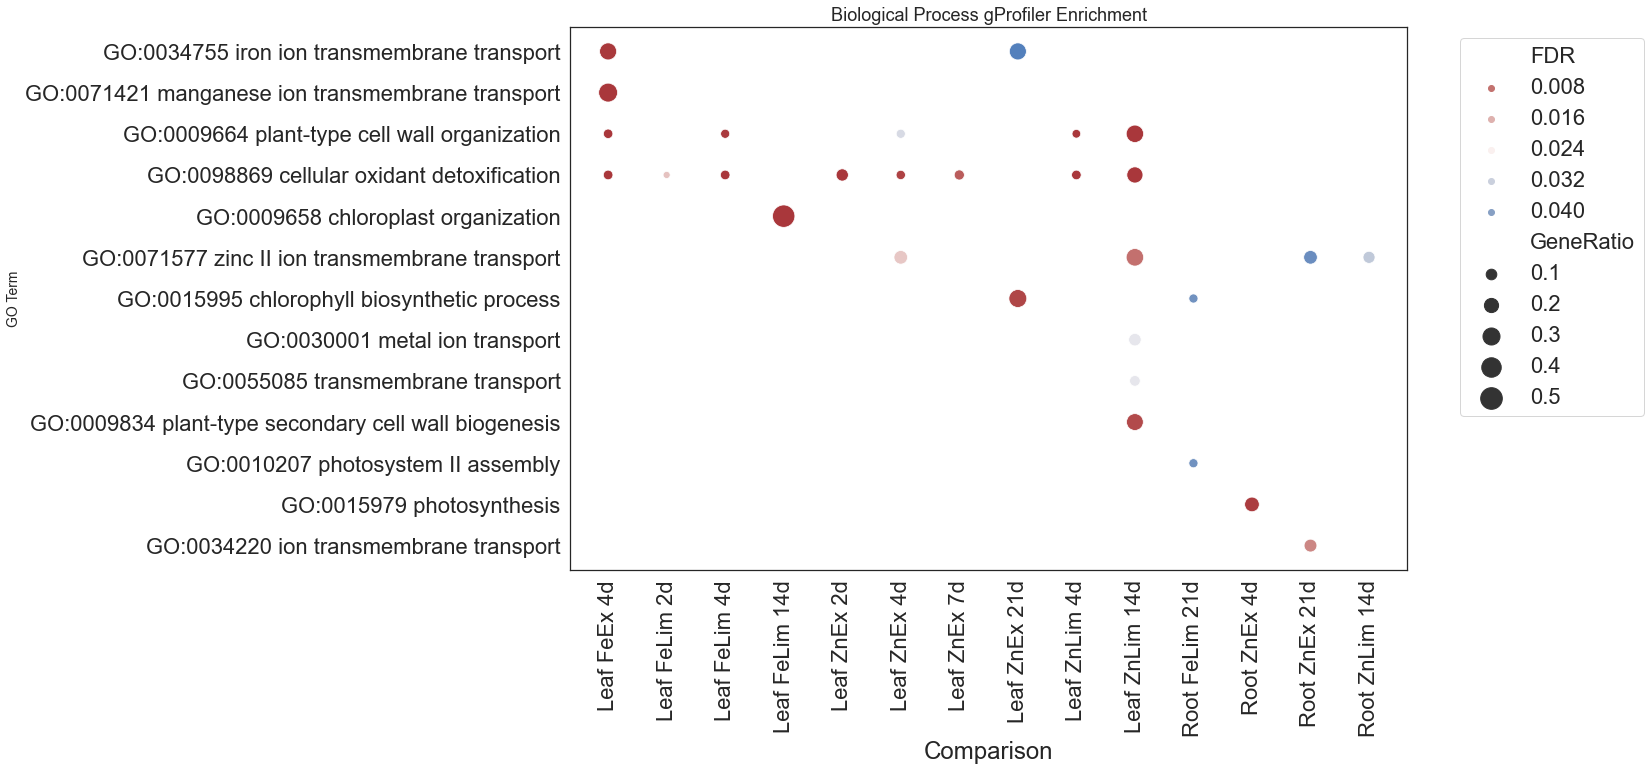

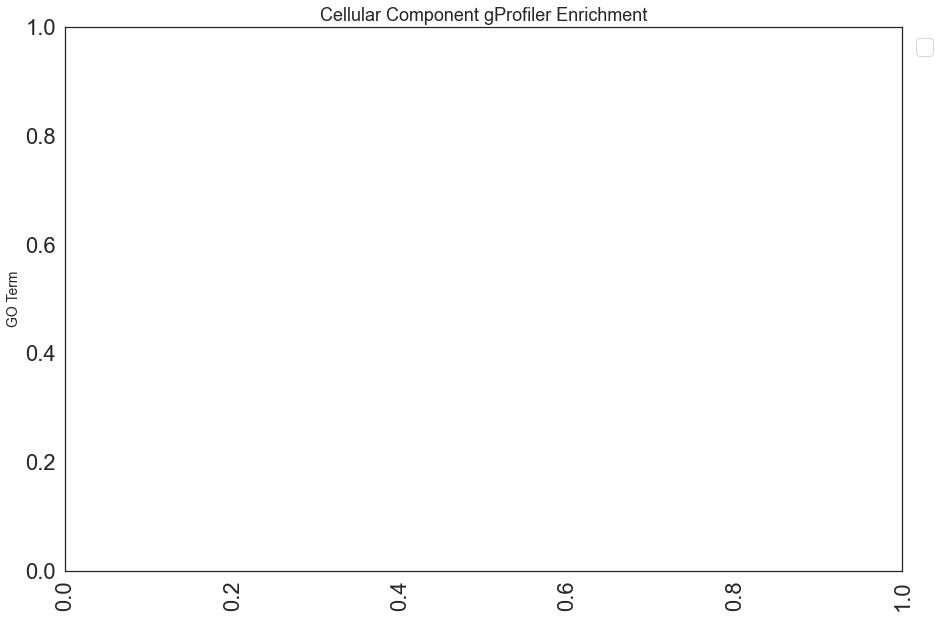

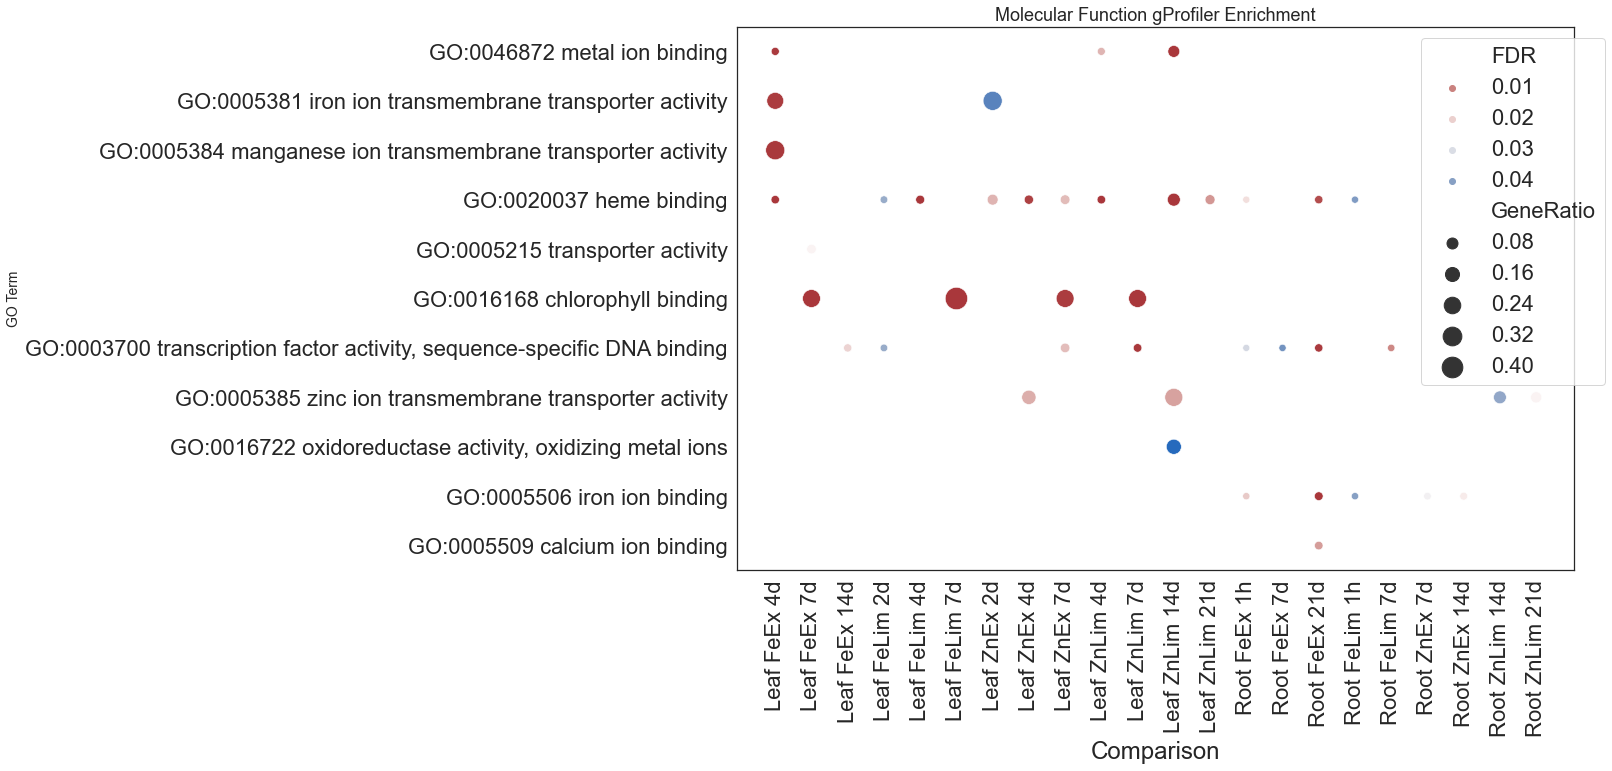

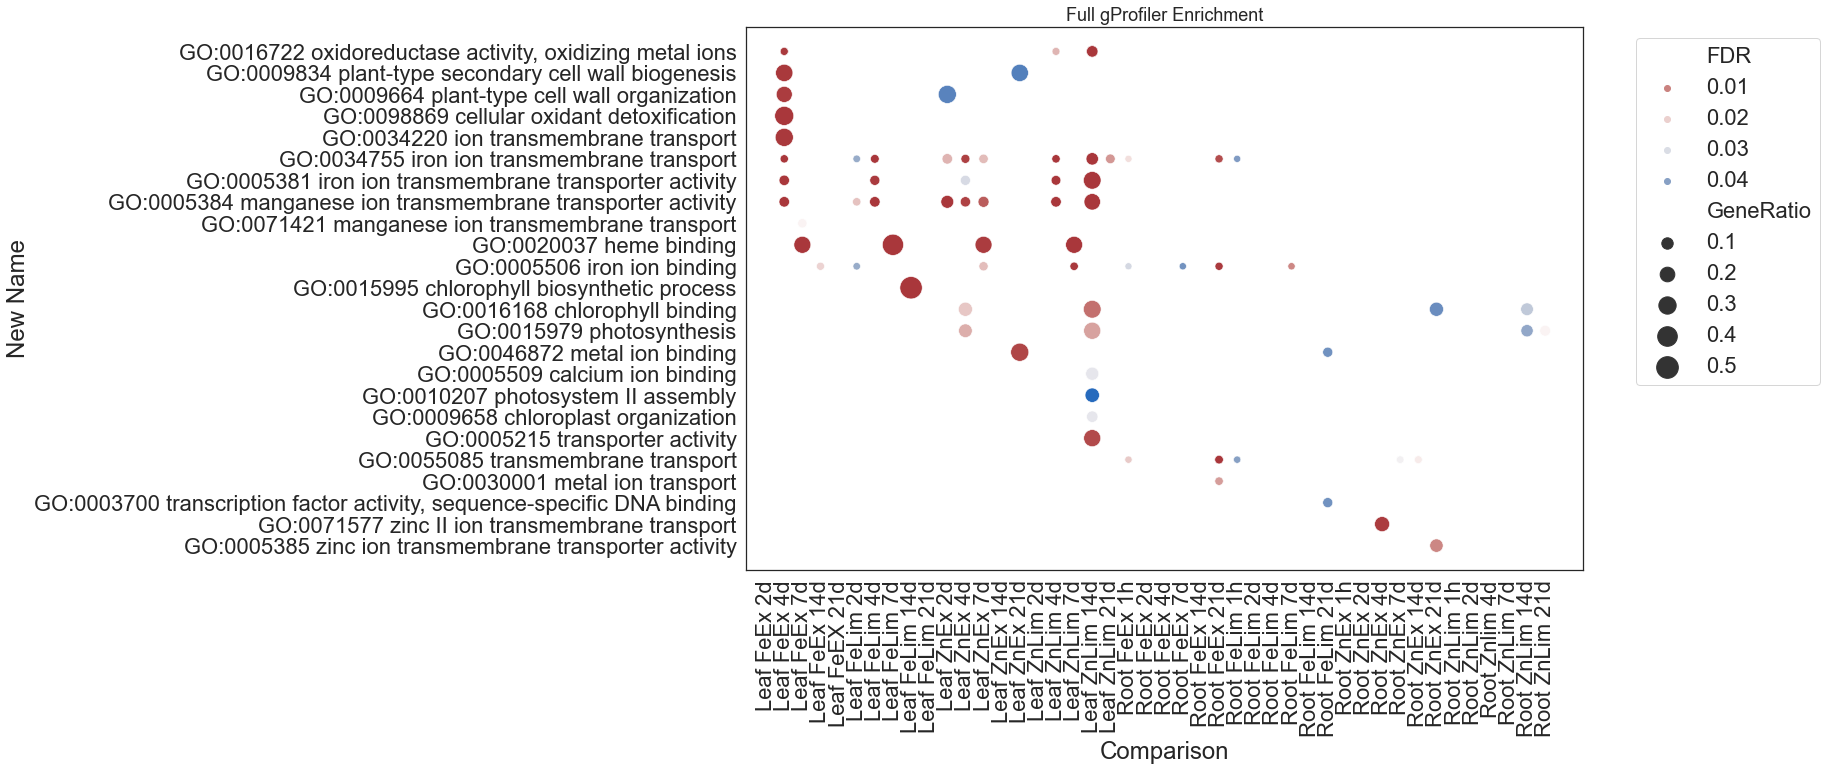

In [14]:
#Create enrichment dotplot for Sorghum
BL.goEnrich_DotPlot(adj_Pthresh=0.05, for_REVIGO=False, full_gProfiler='Sorg_full_go.csv', 
                     output_type='.pdf',
                     plot_width=15, plot_height=10,
                     dot_min_size=50,
                     dot_max_size=500,
                     sort_list=['GO:0016722 oxidoreductase activity, oxidizing metal ions',
                                'GO:0009834 plant-type secondary cell wall biogenesis',
                                'GO:0009664 plant-type cell wall organization',
                                'GO:0098869 cellular oxidant detoxification',
                                'GO:0034220 ion transmembrane transport',
                                'GO:0034755 iron ion transmembrane transport',
                                'GO:0005381 iron ion transmembrane transporter activity',
                                'GO:0005384 manganese ion transmembrane transporter activity',
                                'GO:0071421 manganese ion transmembrane transport',
                                'GO:0020037 heme binding',
                                'GO:0005506 iron ion binding',
                                'GO:0015995 chlorophyll biosynthetic process',
                                'GO:0016168 chlorophyll binding',
                                'GO:0015979 photosynthesis',
                                'GO:0046872 metal ion binding',
                                'GO:0005509 calcium ion binding',
                                'GO:0010207 photosystem II assembly',
                                'GO:0009658 chloroplast organization',
                                'GO:0005215 transporter activity',
                                'GO:0055085 transmembrane transport',
                                'GO:0030001 metal ion transport',
                                'GO:0003700 transcription factor activity, sequence-specific DNA binding',
                                'GO:0071577 zinc II ion transmembrane transport',
                                'GO:0005385 zinc ion transmembrane transporter activity'])

###Enrichment dotplot for Poplar###

not working


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\mclea\OneDrive\Brookhaven\AWS\Jupyter_Notebooks\QPSI\BioinformaticsLibrary.py:462: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.setp(ax, yticklabels=sort_list)


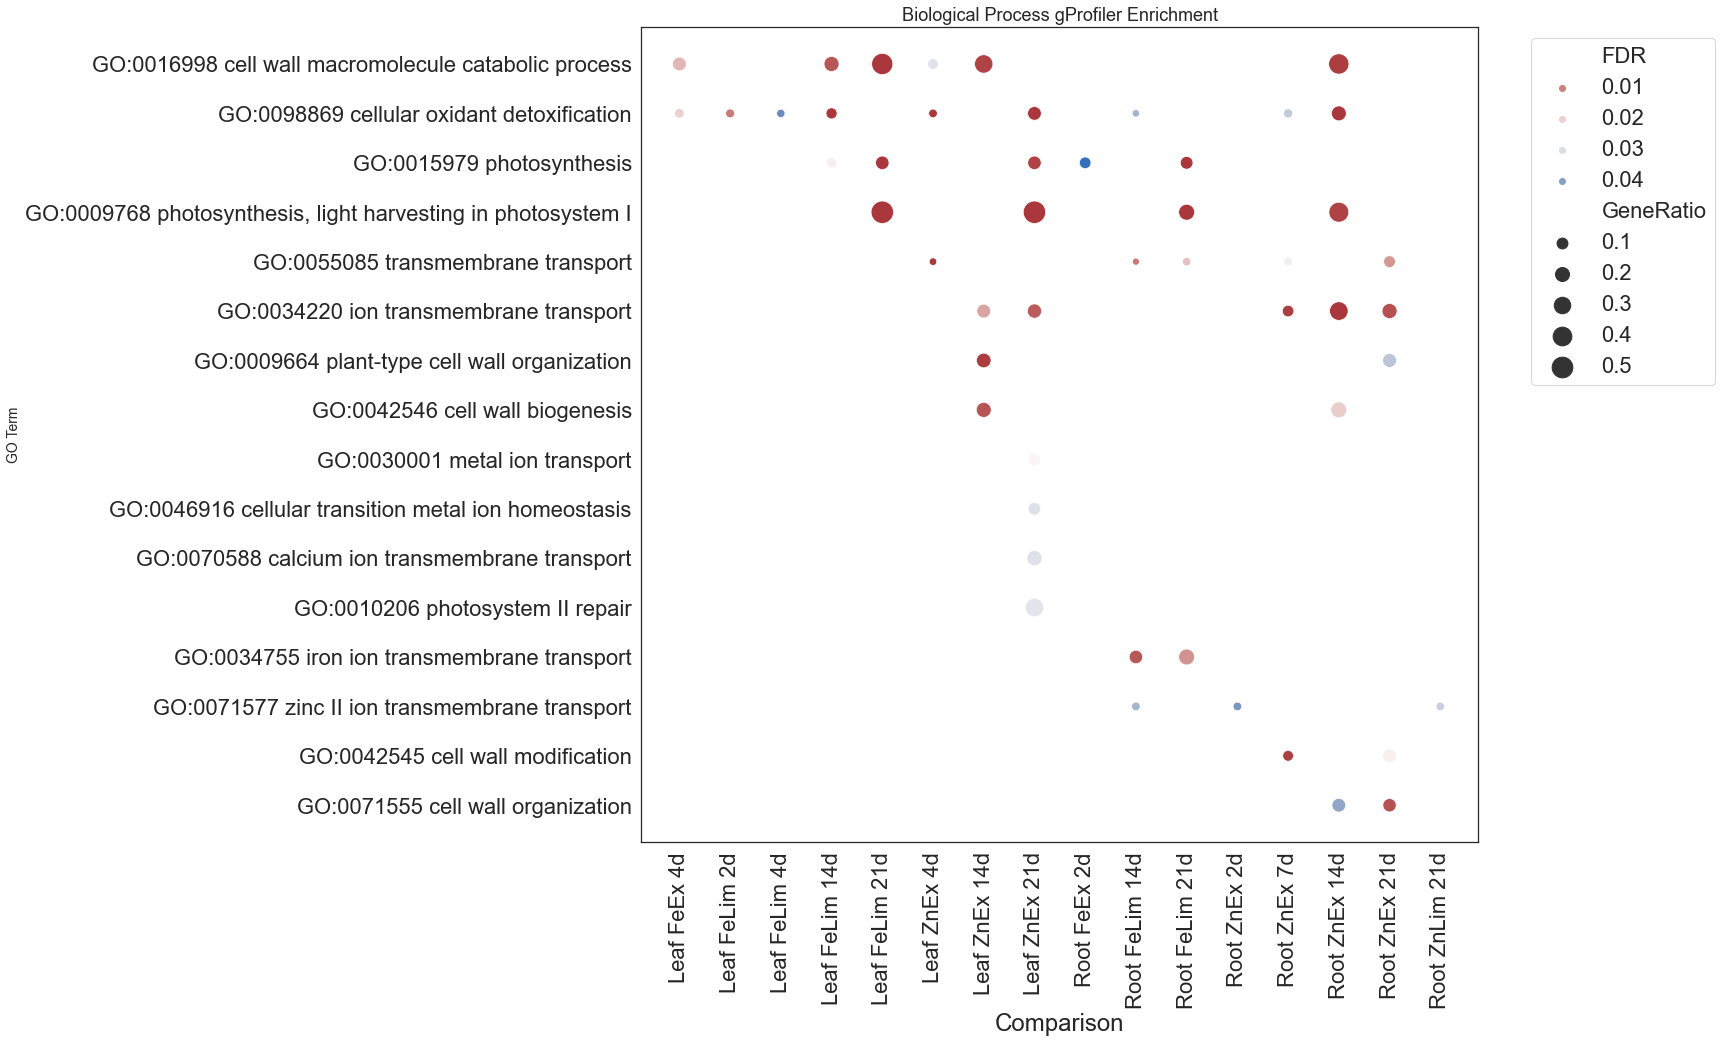

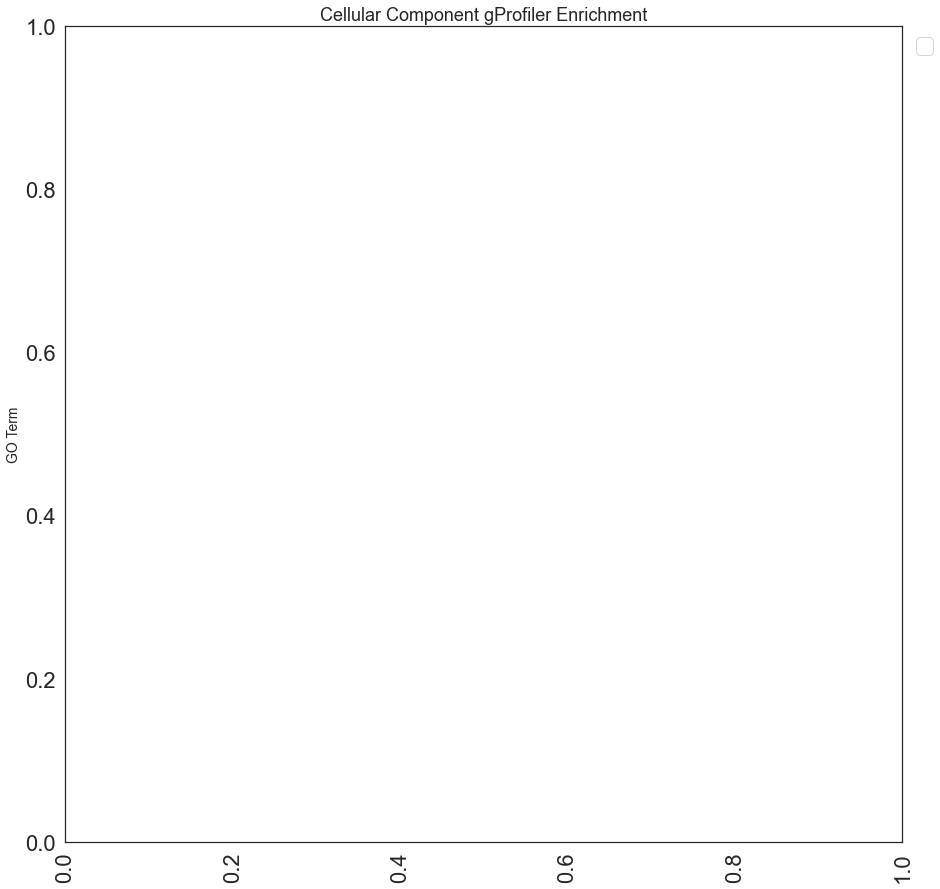

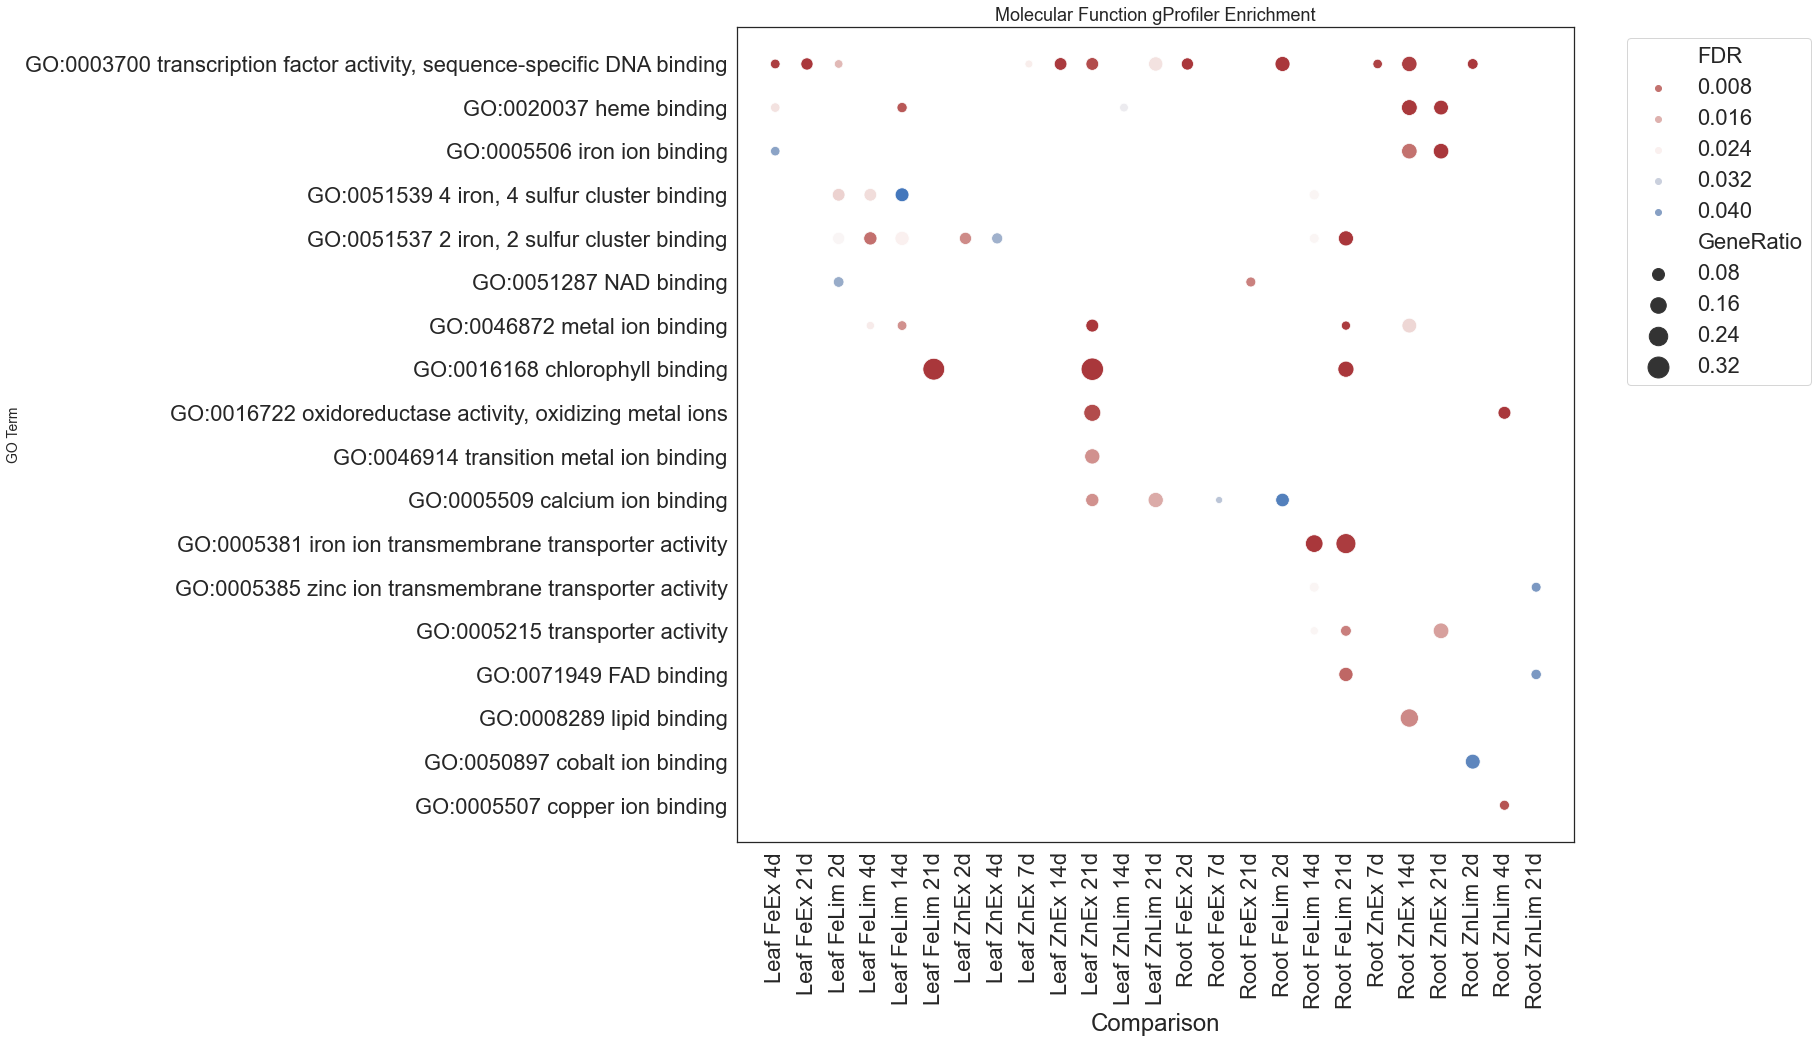

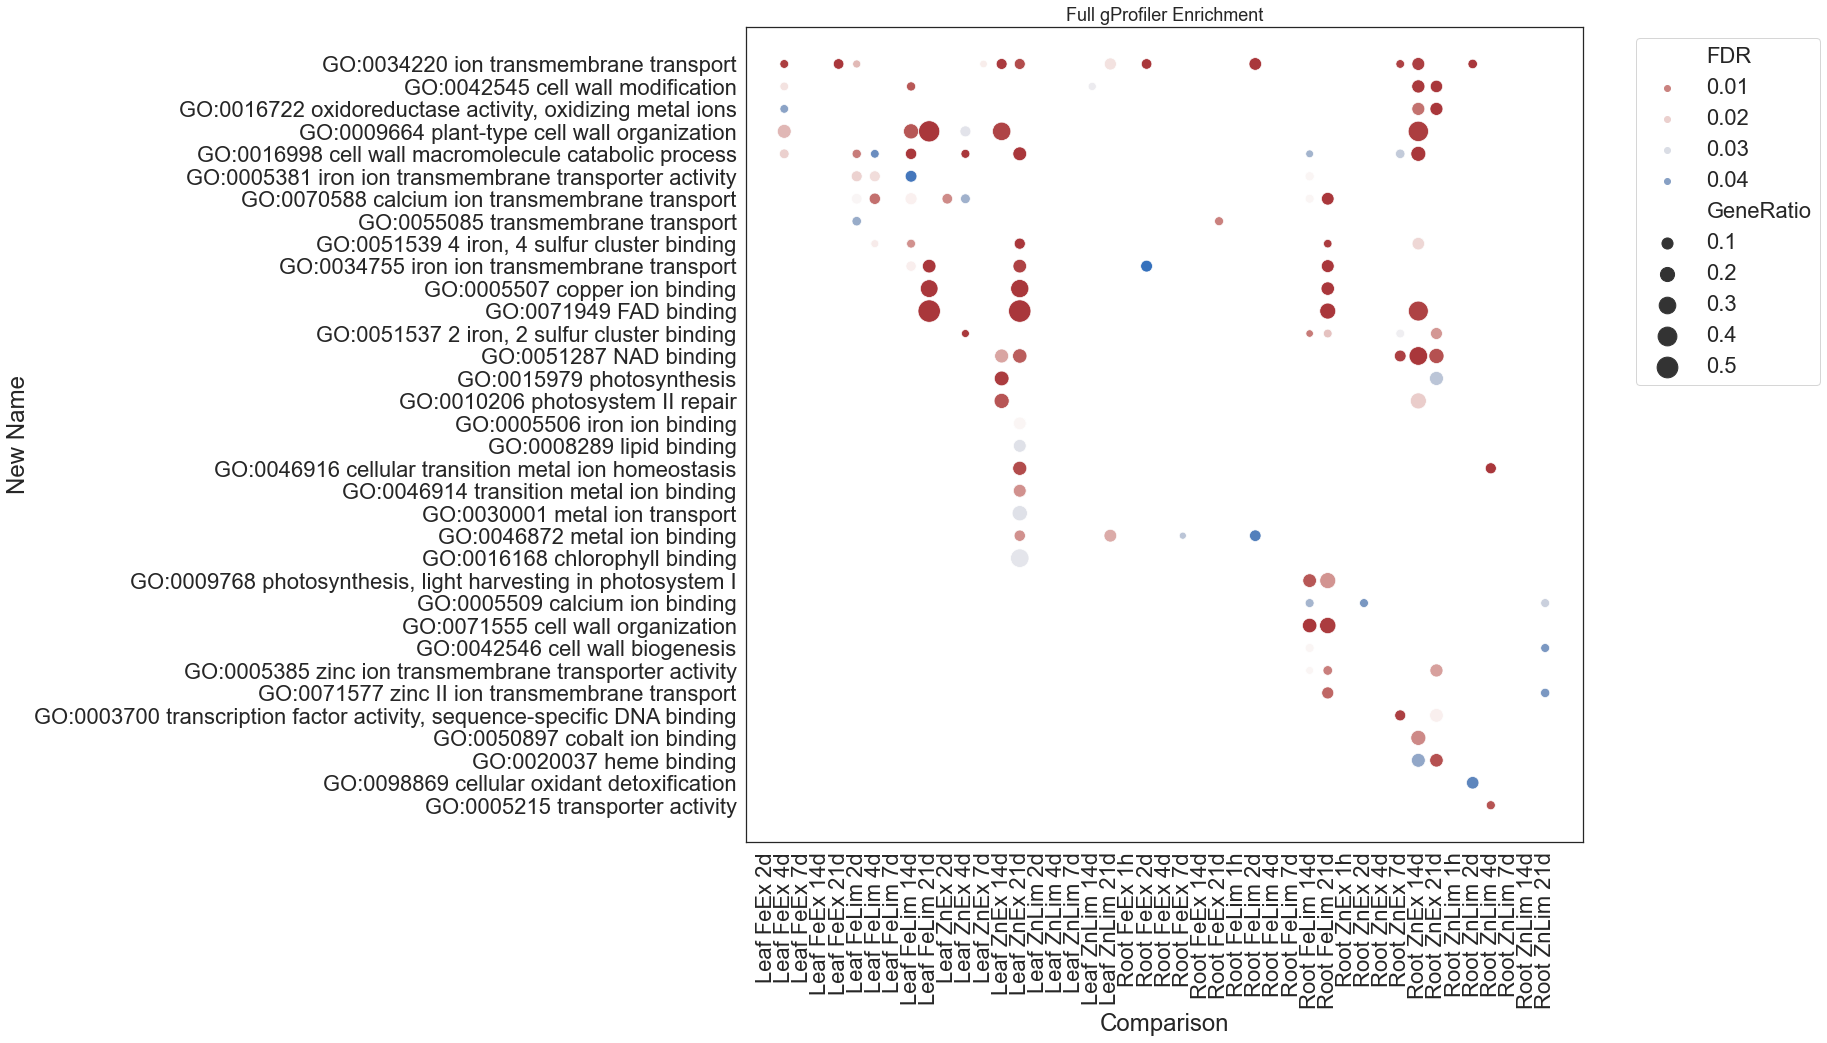

In [15]:
BL.goEnrich_DotPlot(adj_Pthresh=0.05, for_REVIGO=False, full_gProfiler='Pop_full_go.csv', 
                     output_type='.pdf',
                     plot_width=15, plot_height=15,
                     dot_min_size=50,
                     dot_max_size=500,
                     sort_list=['GO:0034220 ion transmembrane transport',
                                'GO:0042545 cell wall modification',
                                'GO:0016722 oxidoreductase activity, oxidizing metal ions',
                                'GO:0009664 plant-type cell wall organization',
                                'GO:0016998 cell wall macromolecule catabolic process',
                                'GO:0005381 iron ion transmembrane transporter activity',
                                'GO:0070588 calcium ion transmembrane transport',
                                'GO:0055085 transmembrane transport',
                                'GO:0051539 4 iron, 4 sulfur cluster binding',
                                'GO:0034755 iron ion transmembrane transport',
                                'GO:0005507 copper ion binding',
                                'GO:0071949 FAD binding',
                                'GO:0051537 2 iron, 2 sulfur cluster binding',
                                'GO:0051287 NAD binding',
                                'GO:0015979 photosynthesis',
                                'GO:0010206 photosystem II repair',
                                'GO:0005506 iron ion binding',
                                'GO:0008289 lipid binding',
                                'GO:0046916 cellular transition metal ion homeostasis',
                                'GO:0046914 transition metal ion binding',
                                'GO:0030001 metal ion transport',
                                'GO:0046872 metal ion binding',
                                'GO:0016168 chlorophyll binding',
                                'GO:0009768 photosynthesis, light harvesting in photosystem I',
                                'GO:0005509 calcium ion binding',
                                'GO:0071555 cell wall organization',
                                'GO:0042546 cell wall biogenesis',
                                'GO:0005385 zinc ion transmembrane transporter activity',
                                'GO:0071577 zinc II ion transmembrane transport',
                                'GO:0003700 transcription factor activity, sequence-specific DNA binding',
                                'GO:0050897 cobalt ion binding',
                                'GO:0020037 heme binding',
                                'GO:0098869 cellular oxidant detoxification',
                                'GO:0005215 transporter activity'])

##Creating split barplot of differentially expressed genes##
###Counting differentially expressed genes based on fold-change and FDR thresholds###
- This will use the count_DEGs() function from the BioinformaticsLibrar.py file
- This function takes a file containing the compiled edgeR or DESeq2 output
- You must specify the suffix used to indictate the fold-change information for each treatment
- You must also specify the suffix used to indicate the FDR/adj. p-value 
- This function will count the number of genes that meet the minimum threshold requirements for each treatment and return the result as a dataframe

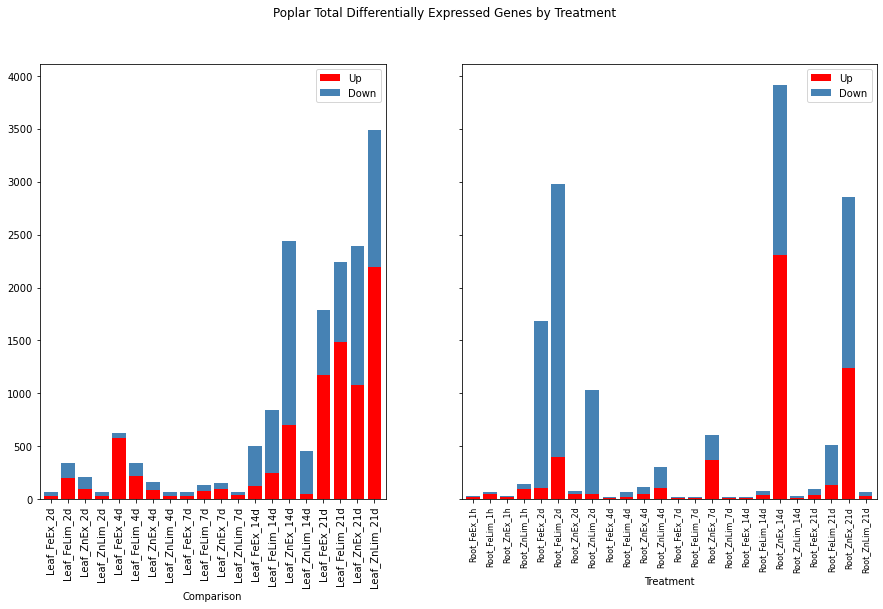

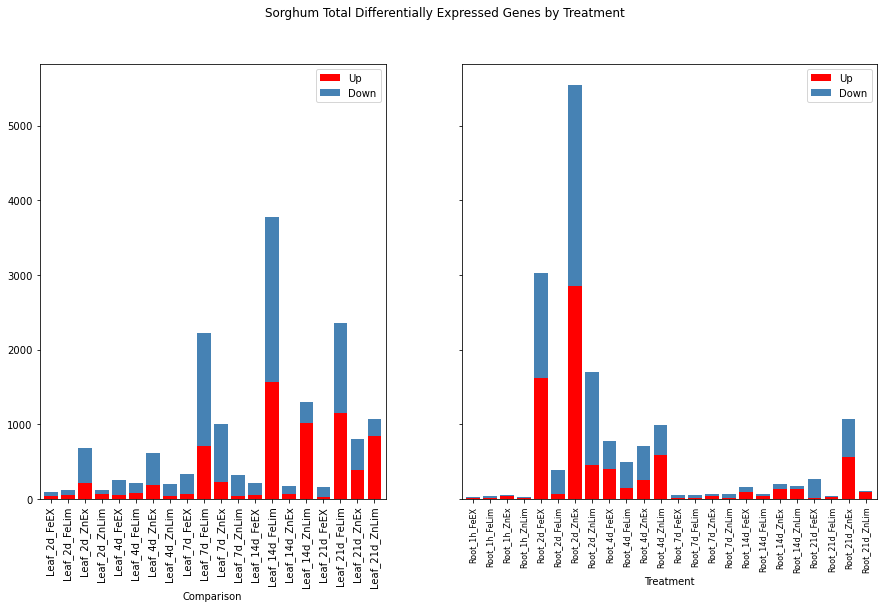

In [8]:
import BioinformaticsLibrary as BL
import matplotlib.pyplot as plt
#Obtain Poplar DEG counts
pop_DEG_count_DF = BL.count_DEGs(DEG_file='Ptr_DGE_results_final.csv', 
                   LFC_suffix='_log2FC', padj_suffix='_padj', 
                   L2FC_threshold=1, adjP_threshold=0.05)

#Subset Poplar results by tissue
leaf_pop_DEG_count = pop_DEG_count_DF[pop_DEG_count_DF['Comparison'].str.contains('Leaf')]
root_pop_DEG_count = pop_DEG_count_DF[pop_DEG_count_DF['Comparison'].str.contains('Root')]

#Plot Leaf and Root side-by-side for Poplar
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8), gridspec_kw={'width_ratios': [5, 6]})
fig.suptitle('Poplar Total Differentially Expressed Genes by Treatment')
leaf_pop_DEG_count.set_index('Comparison').plot(ax=ax1, kind='bar', stacked=True, color=['red', 'steelblue'], width=0.8)
root_pop_DEG_count.set_index('Comparison').plot(ax=ax2, kind='bar', stacked=True, color=['red', 'steelblue'], width=0.8)
plt.xlabel('Treatment')
plt.ylabel('Total DEGs')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('Pop_stacked_split_DEG_by_total.pdf', bbox_inches='tight')

#Export DEG table
pop_DEG_count_DF.to_csv('Poplar_DEG_Counts_Full.csv', index=False)

#Obtain Sorghum DEG counts
sorg_DEG_count_DF = BL.count_DEGs(DEG_file='Sbi_DGE_results_final.csv', 
                   LFC_suffix='_log2FC', padj_suffix='_padj', 
                   L2FC_threshold=1, adjP_threshold=0.05)

#Subset Sorghum results by tissue
leaf_sorg_DEG_count = sorg_DEG_count_DF[sorg_DEG_count_DF['Comparison'].str.contains('Leaf')]
root_sorg_DEG_count = sorg_DEG_count_DF[sorg_DEG_count_DF['Comparison'].str.contains('Root')]

#Plot Leaf and Root side-by-side for Poplar
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 8), gridspec_kw={'width_ratios': [5, 6]})
fig.suptitle('Sorghum Total Differentially Expressed Genes by Treatment')
leaf_sorg_DEG_count.set_index('Comparison').plot(ax=ax1, kind='bar', stacked=True, color=['red', 'steelblue'], width=0.8)
root_sorg_DEG_count.set_index('Comparison').plot(ax=ax2, kind='bar', stacked=True, color=['red', 'steelblue'], width=0.8)
plt.xlabel('Treatment')
plt.ylabel('Total DEGs')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('Sorg_stacked_split_DEG_by_total.pdf', bbox_inches='tight')

#Export DEG table
sorg_DEG_count_DF.to_csv('Sorghum_DEG_Counts_Full.csv', index=False)